In [3]:
import pandas as pd
from fbprophet import Prophet
from alpha_vantage.timeseries import TimeSeries
import matplotlib as plt
%matplotlib inline
import os
import numpy as np
import json
import requests
import pandas as pd

In [4]:
api_key='XXXXX'

In [5]:
msft_stock=requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey=api_key').json()

In [6]:
msft_stock_df=pd.DataFrame(msft_stock["Time Series (Daily)"]).transpose()

In [7]:
msft_stock_df.tail()

,1. open,2. high,3. low,4. close,5. volume
1998-01-08,128.6300,132.1300,127.5000,130.5000,9702400
1998-01-07,129.8800,131.1900,127.5000,129.5600,7686600
1998-01-06,129.7500,133.0000,129.2500,131.1300,8479300
1998-01-05,131.2500,133.6300,127.8700,130.3800,10047200
1998-01-02,129.6300,131.5000,129.5000,131.1300,4968500


In [8]:
#msft_stock_df.to_json(r'msft_stock_history.json')

In [9]:
msft_stock_df=msft_stock_df.reset_index()
msft_stock_df.tail()

,index,1. open,2. high,3. low,4. close,5. volume
5412,1998-01-08,128.6300,132.1300,127.5000,130.5000,9702400
5413,1998-01-07,129.8800,131.1900,127.5000,129.5600,7686600
5414,1998-01-06,129.7500,133.0000,129.2500,131.1300,8479300
5415,1998-01-05,131.2500,133.6300,127.8700,130.3800,10047200
5416,1998-01-02,129.6300,131.5000,129.5000,131.1300,4968500


In [10]:
msft_stock_df.columns  

Index(['index', '1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [11]:
msft_stock_df['index'] =  pd.to_datetime(msft_stock_df['index'], format='%Y-%m-%d')
msft_stock_df=msft_stock_df[ msft_stock_df['index']>='2018-01-01']


In [12]:
msft_stock_df.head()

,index,1. open,2. high,3. low,4. close,5. volume
0,2019-07-15,139.4400,139.5400,138.4600,138.9000,16646179
1,2019-07-12,138.8500,139.1300,138.0099,138.9000,18936832
2,2019-07-11,138.2000,139.2200,137.8700,138.4000,22327942
3,2019-07-10,137.1300,138.5800,137.0200,137.8500,24204362
4,2019-07-09,136.0000,136.9700,135.8000,136.4600,19953097


In [13]:
msft_stock_df.shape[0]

385

In [14]:
#Split the data
#Training data: first 80% of the data. To fit
#Test data: remaining 20%
msft_stock_df_training=msft_stock_df.iloc[int(0.2*msft_stock_df.shape[0]):msft_stock_df.shape[0]-1]
msft_stock_df_testing=msft_stock_df.iloc[0:int(0.2*msft_stock_df.shape[0])]

In [15]:
print(msft_stock_df_training.shape)
print(msft_stock_df_testing.shape)

(307, 6)
(77, 6)


In [16]:
msft_stock_df_testing.head()

,index,1. open,2. high,3. low,4. close,5. volume
0,2019-07-15,139.4400,139.5400,138.4600,138.9000,16646179
1,2019-07-12,138.8500,139.1300,138.0099,138.9000,18936832
2,2019-07-11,138.2000,139.2200,137.8700,138.4000,22327942
3,2019-07-10,137.1300,138.5800,137.0200,137.8500,24204362
4,2019-07-09,136.0000,136.9700,135.8000,136.4600,19953097


In [17]:
msft_stock_df_training.tail()

,index,1. open,2. high,3. low,4. close,5. volume
379,2018-01-09,88.6500,88.7272,87.8600,88.2200,19390427
380,2018-01-08,88.2000,88.5800,87.6046,88.2800,20293930
381,2018-01-05,87.6600,88.4100,87.4300,88.1900,22526563
382,2018-01-04,86.5900,87.6600,86.5700,87.1100,21145985
383,2018-01-03,86.0550,86.5100,85.9700,86.3500,24173064


In [18]:
#msft_stock_df_reduced_training
msft_stock_df_training.columns

Index(['index', '1. open', '2. high', '3. low', '4. close', '5. volume'], dtype='object')

In [19]:
msft_stock_df_testing.head()

,index,1. open,2. high,3. low,4. close,5. volume
0,2019-07-15,139.4400,139.5400,138.4600,138.9000,16646179
1,2019-07-12,138.8500,139.1300,138.0099,138.9000,18936832
2,2019-07-11,138.2000,139.2200,137.8700,138.4000,22327942
3,2019-07-10,137.1300,138.5800,137.0200,137.8500,24204362
4,2019-07-09,136.0000,136.9700,135.8000,136.4600,19953097


In [20]:
msft_stock_df_reduced_training=pd.DataFrame(msft_stock_df_training[['index','4. close']])
msft_stock_df_reduced_training.columns=['ds','y']
msft_stock_df_reduced_testing=pd.DataFrame(msft_stock_df_testing[['index','4. close']])
msft_stock_df_reduced_testing.columns=['ds','y']

In [21]:
msft_stock_df_reduced_training.head()

,ds,y
77,2019-03-25,117.6600
78,2019-03-22,117.0500
79,2019-03-21,120.2200
80,2019-03-20,117.5200
81,2019-03-19,117.6500


In [22]:
msft_stock_df_reduced_testing.head()

,ds,y
0,2019-07-15,138.9000
1,2019-07-12,138.9000
2,2019-07-11,138.4000
3,2019-07-10,137.8500
4,2019-07-09,136.4600


In [23]:
#msft_stock_df_reduced['ds'] =  pd.to_datetime(msft_stock_df_reduced['ds'], format='%Y-%m-%d')

In [24]:
# Python
m = Prophet()
m.fit(msft_stock_df_reduced_training)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\jonat\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [25]:
# Python
#future = m.make_future_dataframe(periods=365)
#future.tail()

In [26]:
#forecast = m.predict(future)
forecast=m.predict(msft_stock_df_reduced_testing)
forecast['day_week'] = forecast.ds.dt.weekday_name
forecast = forecast[forecast.day_week != 'Sunday']
forecast = forecast[forecast.day_week != 'Saturday']
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
72,2019-07-09,127.691235,121.368534,134.185603
73,2019-07-10,127.706348,121.263001,133.759999
74,2019-07-11,127.894608,121.342995,134.202018
75,2019-07-12,128.060251,121.328786,134.670973
76,2019-07-15,128.241294,121.202254,135.043729


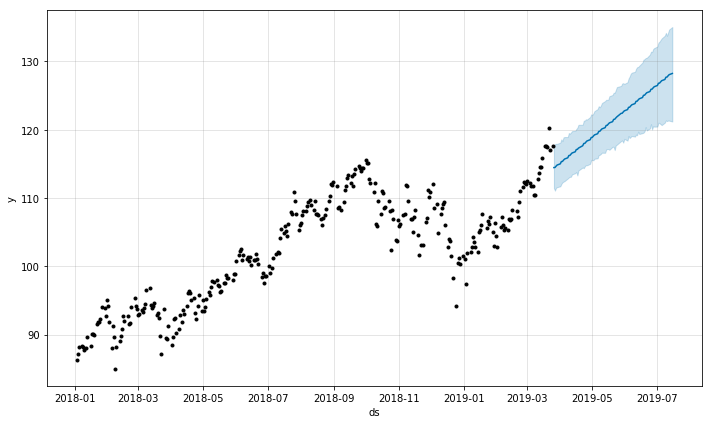

In [27]:
# Python
fig1 = m.plot(forecast)

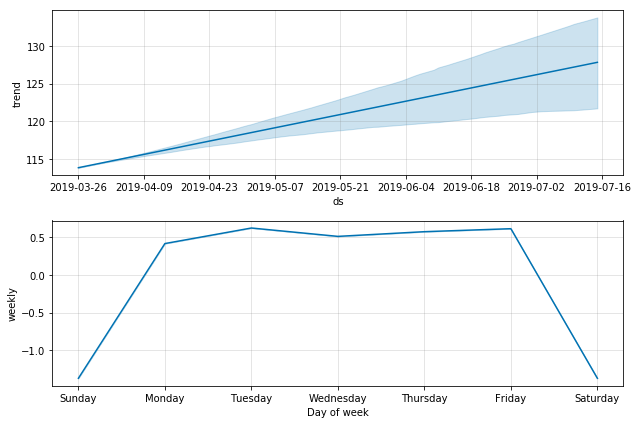

In [28]:
# Python
fig2 = m.plot_components(forecast)


In [29]:
# Python
#from fbprophet.plot import plot_plotly
#import plotly.offline as py
#py.init_notebook_mode()

#fig = plot_plotly(m, forecast)  # This returns a plotly Figure
#py.iplot(fig)

In [30]:
#Comparison with real values
msft_stock_df_reduced=pd.DataFrame(msft_stock_df[['index','4. close']])
msft_stock_df_reduced.columns=['ds','y']

In [31]:
msft_stock_df_reduced.tail()

,ds,y
380,2018-01-08,88.2800
381,2018-01-05,88.1900
382,2018-01-04,87.1100
383,2018-01-03,86.3500
384,2018-01-02,85.9500


In [32]:
print(forecast.shape)
print(msft_stock_df_reduced.shape)

(77, 17)
(385, 2)


In [33]:
metric_df = forecast.set_index('ds')[['yhat']].join(msft_stock_df_reduced.set_index('ds').y).reset_index()
metric_df.shape

(77, 3)

In [34]:
#remove NaN
metric_df.dropna(inplace=True)
metric_df.tail()

,ds,yhat,y
72,2019-07-09,127.691235,136.4600
73,2019-07-10,127.706348,137.8500
74,2019-07-11,127.894608,138.4000
75,2019-07-12,128.060251,138.9000
76,2019-07-15,128.241294,138.9000


In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,explained_variance_score

In [36]:
r2_score(metric_df.y, metric_df.yhat)

-0.33348712918598866

In [37]:
mean_squared_error(metric_df.y, metric_df.yhat)

53.02632710680534

In [38]:
explained_variance_score(metric_df.y,metric_df.yhat, multioutput='variance_weighted')

0.74541340164012

In [20]:
# Python
#from fbprophet.diagnostics import cross_validation
#df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
#df_cv.head()

In [21]:
# Python
#from fbprophet.diagnostics import performance_metrics
#df_p = performance_metrics(df_cv)
#df_p.tail()

In [22]:
#np.mean(df_p['mse'])

In [23]:
# Python
#from fbprophet.plot import plot_cross_validation_metric
#fig = plot_cross_validation_metric(df_cv, metric='rmse')


<h3>References:</h3>
https://github.com/urgedata/pythondata/blob/master/fbprophet/fbprophet_metrics.ipynb<br>
https://medium.com/mongolian-data-stories/using-facebooks-prophet-to-predict-mongolian-stocks-cdf4feabd558<br>
https://facebook.github.io/prophet/docs/